In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd 

from sklearn.model_selection import train_test_split

from multiprocessing import cpu_count

# Oversampling

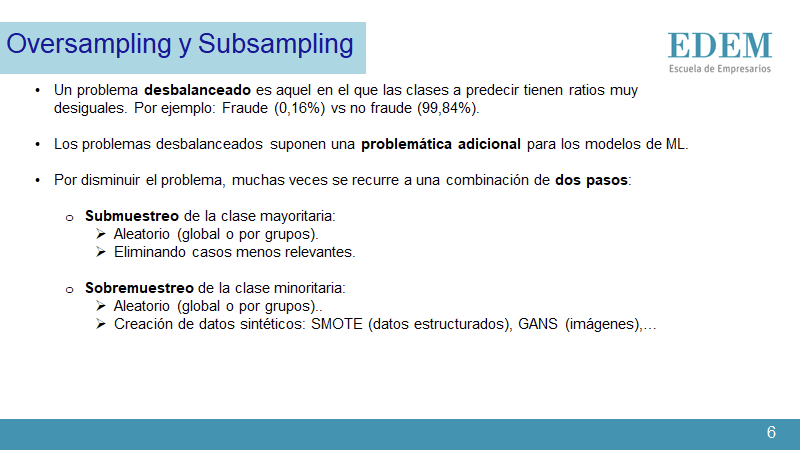

**Los problemas desequilibrados** son aquellos problemas de clasificación en los que la proporción entre las distintas clases es significativamente diferente. Estos problemas presentan algunas particularidades que los hacen un poco más difíciles de resolver. En particular, la elección de la métrica debe tener en cuenta este desequilibrio de clases, y deben llevarse a cabo algunos pasos adicionales para evitar que el modelo se centre demasiado en las clases más frecuentes y tenga un rendimiento deficiente en las menos frecuentes.

Nos centraremos en el problema de clasificación binaria, en el que hay una **clase mayoritaria** y una **clase minoritaria**. Por ejemplo, el problema de clasificación de la atención sanitaria en el que trabajamos en clases anteriores podría considerarse un problema desequilibrado, ya que la proporción de exitus (clase minoritaria) es aproximadamente del 5%. Otro ejemplo sería el problema de detección de fraude en Iberia Express, donde la clase minoritaria (transacción fraudulenta) nunca supera el 0,2% de los datos, ratio que se consideraría un verdadero problema de clasificación desequilibrado.

Las métricas que se pueden aplicar a problemas desequilibrados son las basadas en el área bajo una curva. Ya hemos visto la curva ROC y la curva precisión-recuerdo. De estas dos, el área bajo la curva de precisión-recuperación es ligeramente preferible cuando se trata de problemas muy desequilibrados.

En cuanto a los pasos de preprocesamiento adicionales que se pueden llevar a cabo para ayudar al modelo a resolver problemas desequilibrados, trataremos el **sobremuestreo** de la clase minoritaria y el **submuestreo** de la clase mayoritaria. Aquí nos centraremos en el sobremuestreo.

## Load Data

In [2]:
dat = pd.read_csv("../datasets/i2.csv", sep = ";")
dat = dat.drop(['user', 'booking_date', 'origin_airport', 'airline'], axis = 1) # Remove non-numerical variables for this notebook
dat.head()

,price,sales channel,ant
0,NaN,online,NaN
1,147.500000,online,38.0
2,24.049999,online,19.0
3,59.709999,online,8.0
4,37.299999,call center,4.0


Imaginemos que queremos predecir el canal de ventas de una predicción concreta. Por lo tanto, nuestro valor objetivo es la columna *canal de ventas*. Como nos estamos centrando en el caso de clasificación binaria, descartaremos las transacciones de la agencia de viajes.

In [3]:
dat = dat[dat['sales channel'] != 'travel agency']

In [4]:
100*dat.groupby(['sales channel'])['sales channel'].agg(['count'])/dat.shape[0]

,count
sales channel,
call center,5.882353
online,94.117647


Esto puede considerarse un problema de clasificación desequilibrada. Veamos cómo aplicarle el sobremuestreo.

## Duplicar casos

Una forma sencilla de aumentar los ejemplos de clases minoritarias es crear duplicados de las instancias de clases minoritarias existentes.

A primera vista, esto podría parecer poco útil, ya que sólo se está repitiendo información. Sin embargo, esto puede permitir que el modelo se centre más en las clases minoritarias, dando más importancia a un ejemplo de clase minoritaria que a uno de clase mayoritaria. Sería como aplicar distintos pesos a cada fila, dependiendo de si pertenece a una clase o a otra.

Esto se puede hacer fácilmente con la función de ejemplo de pandas.

In [5]:
?dat.sample

Signature:
dat.sample(
    n: 'int | None' = None,
    frac: 'float | None' = None,
    replace: 'bool_t' = False,
    weights=None,
    random_state: 'RandomState | None' = None,
    axis: 'Axis | None' = None,
    ignore_index: 'bool_t' = False,
) -> 'NDFrameT'
Docstring:
Return a random sample of items from an axis of object.

You can use `random_state` for reproducibility.

Parameters
----------
n : int, optional
    Number of items from axis to return. Cannot be used with `frac`.
    Default = 1 if `frac` = None.
frac : float, optional
    Fraction of axis items to return. Cannot be used with `n`.
replace : bool, default False
    Allow or disallow sampling of the same row more than once.
weights : str or ndarray-like, optional
    Default 'None' results in equal probability weighting.
    If passed a Series, will align with target object on index. Index
    values in weights not found in sampled object will be ignored and
    index values in sampled object not in weights will be 

In [6]:
dat['sales channel'].value_counts()

online         624
call center     39
Name: sales channel, dtype: int64

In [7]:
oversampling_rows = dat[dat['sales channel'] == 'call center'].sample(int(0.25*dat[dat['sales channel'] == 'online'].shape[0]), 
                                                                      replace = True, 
                                                                      random_state = 0, 
                                                                      axis = 0)

In [8]:
oversampling_rows.shape

(156, 3)

In [9]:
dat_duplicates = pd.concat([dat, oversampling_rows])
100*dat_duplicates.groupby(['sales channel'])['sales channel'].agg(['count'])/dat_duplicates.shape[0]

,count
sales channel,
call center,23.809524
online,76.190476


In [10]:
dat['sales channel'].value_counts()

online         624
call center     39
Name: sales channel, dtype: int64

In [11]:
dat_duplicates['sales channel'].value_counts()

online         624
call center    195
Name: sales channel, dtype: int64

Hemos reducido el desequilibrio en el target.

## SMOTE

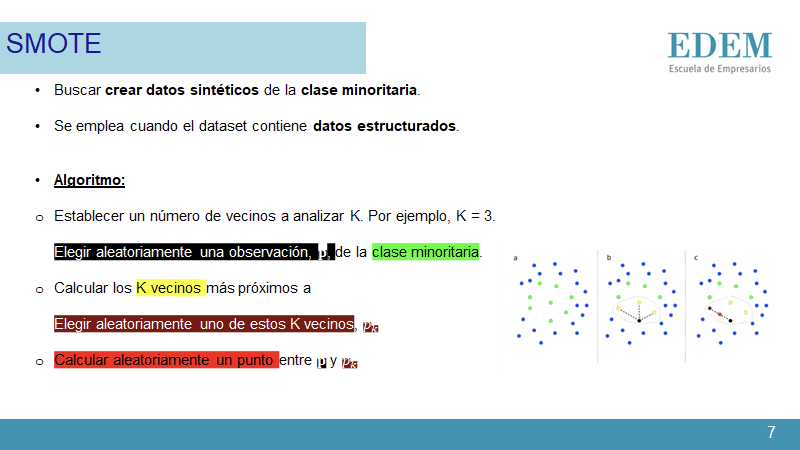

Synthetic Minority Oversampling TEchnique, **SMOTE**, es una técnica de sobremuestreo realmente popular y útil. Su objetivo es crear ejemplos sintéticos de la clase minoritaria, basándose en la distribución de los ejemplos disponibles de esa clase en el conjunto de datos. 

En concreto, primero se elige un ejemplo aleatorio de la clase minoritaria. A continuación, se encuentran k de los vecinos más cercanos de ese ejemplo (por defecto k=5). Se elige un vecino al azar de entre esos k y se crea un ejemplo sintético en un punto elegido al azar entre los dos ejemplos en el espacio de características.

Visualmente, SMOTE puede ilustrarse como sigue:

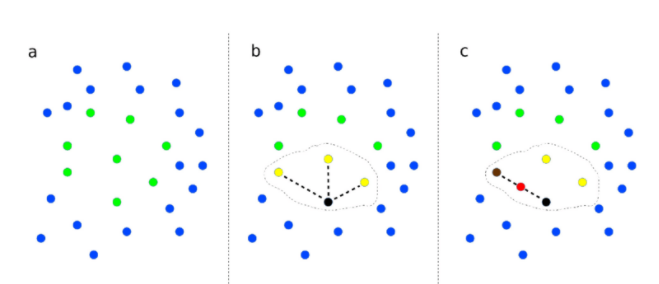

Está disponible en el paquete *imbalanced-learn* (ejecute pip install -U imbalanced-learn para instalarlo).

In [12]:
from imblearn.over_sampling import SMOTE
?SMOTE

Init signature:
SMOTE(
    *,
    sampling_strategy='auto',
    random_state=None,
    k_neighbors=5,
    n_jobs=None,
)
Docstring:     
Class to perform over-sampling using SMOTE.

This object is an implementation of SMOTE - Synthetic Minority
Over-sampling Technique as presented in [1]_.

Read more in the :ref:`User Guide <smote_adasyn>`.

Parameters
----------
sampling_strategy : float, str, dict or callable, default='auto'
    Sampling information to resample the data set.

    - When ``float``, it corresponds to the desired ratio of the number of
      samples in the minority class over the number of samples in the
      majority class after resampling. Therefore, the ratio is expressed as
      :math:`\alpha_{os} = N_{rm} / N_{M}` where :math:`N_{rm}` is the
      number of samples in the minority class after resampling and
      :math:`N_{M}` is the number of samples in the majority class.

        .. warning::
           ``float`` is only available for **binary** classification

In [13]:
sm = SMOTE(sampling_strategy = 0.4,
           random_state = 0,
           k_neighbors = 5,
           n_jobs = cpu_count()-1)

In [14]:
X_res, y_res = sm.fit_resample(dat.drop('sales channel', axis = 1).fillna(0), dat['sales channel'].fillna(0))

/Users/mimove/Library/Python/3.10/lib/python/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [15]:
dat_smote = pd.concat([X_res, y_res], axis = 1)

In [16]:
100*dat_smote.groupby(['sales channel'])['sales channel'].agg(['count'])/dat_smote.shape[0]

,count
sales channel,
call center,28.522337
online,71.477663


In [17]:
dat['sales channel'].value_counts()

online         624
call center     39
Name: sales channel, dtype: int64

In [18]:
dat_smote['sales channel'].value_counts()

online         624
call center    249
Name: sales channel, dtype: int64

## Ejemplo

Trabajemos ahora con un conjunto de datos artificial.

In [19]:
from sklearn.datasets import make_classification

In [20]:
?make_classification

Signature:
make_classification(
    n_samples=100,
    n_features=20,
    *,
    n_informative=2,
    n_redundant=2,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=2,
    weights=None,
    flip_y=0.01,
    class_sep=1.0,
    hypercube=True,
    shift=0.0,
    scale=1.0,
    shuffle=True,
    random_state=None,
)
Docstring:
Generate a random n-class classification problem.

This initially creates clusters of points normally distributed (std=1)
about vertices of an ``n_informative``-dimensional hypercube with sides of
length ``2*class_sep`` and assigns an equal number of clusters to each
class. It introduces interdependence between these features and adds
various types of further noise to the data.

Without shuffling, ``X`` horizontally stacks features in the following
order: the primary ``n_informative`` features, followed by ``n_redundant``
linear combinations of the informative features, followed by ``n_repeated``
duplicates, drawn randomly with replacement from the infor

In [21]:
X, y = make_classification(n_samples=1000, weights=[0.99], flip_y=0, random_state=14)

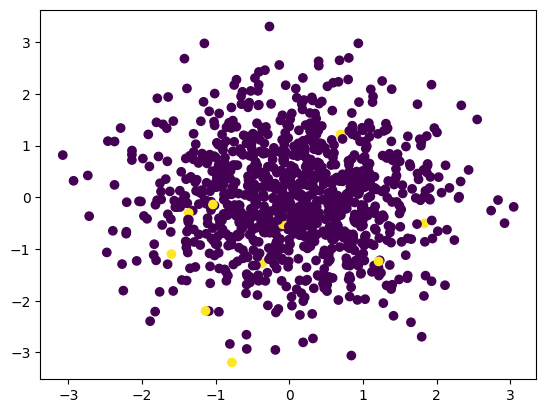

In [22]:
# scatter plot of examples by class label
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.show()

In [23]:
unique, counts = np.unique(y, return_counts=True);
print(np.asarray((unique, counts)).T);

[[  0 990]
 [  1  10]]


Apliquemos SMOTE a este conjunto de datos.

In [24]:
sm = SMOTE(sampling_strategy = 0.2,
           random_state = 0,
           k_neighbors = 5,
           n_jobs = cpu_count()-1)

In [25]:
X_smote, y_smote = sm.fit_resample(X, y)

/Users/mimove/Library/Python/3.10/lib/python/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [26]:
unique, counts = np.unique(y_smote, return_counts=True);
print(np.asarray((unique, counts)).T);

[[  0 990]
 [  1 198]]


Y construyamos modelos con y sin sobremuestreo.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.3, random_state=1);
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, y_smote, stratify = y_smote, test_size=0.3, random_state=1);


In [28]:
# 1) Import model
from sklearn.linear_model import LogisticRegression as model_constructor

# 2) Import metric
from sklearn.metrics import roc_auc_score as metric

# [3] Define model
model = model_constructor(penalty = 'l1', 
                          solver = 'liblinear', 
                          C = 1, 
                          random_state = 0)

# [4] Train model
model.fit(X_train, y_train) ## Only train!!! Requires target y for being supervised learning.

# [5] Predict
pred_train = model.predict_proba(X_train) 
pred_test = model.predict_proba(X_test) 

# [6] Compute metric
metric_train = metric(y_train, pred_train[:,1])
metric_test = metric(y_test, pred_test[:,1])

In [29]:
# 1) Import model
from sklearn.linear_model import LogisticRegression as model_constructor

# 2) Import metric
from sklearn.metrics import roc_auc_score as metric

# [3] Define model
model = model_constructor(penalty = 'l1', 
                          solver = 'liblinear', 
                          C = 1, 
                          random_state = 0)

# [4] Train model
model.fit(X_smote_train, y_smote_train) ## Only train!!! Requires target y for being supervised learning.

# [5] Predict
pred_train = model.predict_proba(X_smote_train) 
pred_test = model.predict_proba(X_smote_test) 

# [6] Compute metric
metric_smote_train = metric(y_smote_train, pred_train[:,1])
metric_smote_test = metric(y_smote_test, pred_test[:,1])

In [30]:
# print error
print('AUC train = %.2f - AUC test = %.2f' 
      % (metric_train, metric_test))

AUC train = 1.00 - AUC test = 0.63


In [31]:
# print error
print('AUC SMOTE train = %.2f - AUC SMOTE test = %.2f' 
      % (metric_smote_train, metric_smote_test))

AUC SMOTE train = 0.99 - AUC SMOTE test = 0.99


## Definir Función

Vamos a crear nuestra propia función personalizada para aplicar sobremuestreo utilizando smote o duplicados.

In [32]:
def oversampling(X, y, p, type_value = 'SMOTE', k = 5, random_state = 0, n_jobs = 1):    
    if type_value == 'SMOTE':
        sm = SMOTE(sampling_strategy = p,
           random_state = random_state,
           k_neighbors = k,
           n_jobs = n_jobs)
        X, y = sm.fit_resample(X, y)
        return X,y
    elif type_value == 'duplicates':
        majority_class = stats.mode(y)[0][0]
        oversampling_rows = pd.concat([pd.DataFrame(X[y == majority_class]), 
                                       pd.Series(y[y == majority_class])], 
                                      axis = 1).sample(frac = p, 
                                                                      replace = True, 
                                                                      random_state = random_state, 
                                                                      axis = 0)
        X = pd.concat([pd.concat([pd.DataFrame(X), pd.Series(y)], axis = 1), oversampling_rows]) 
        return X                                        
                                                                                        

In [33]:
import preprocessing_functions

ModuleNotFoundError: No module named 'preprocessing_functions'

In [ ]:
X_new, y_new = oversampling(X, y, p = 0.25)
pd.DataFrame(X_new)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.761381,-0.726303,-0.882760,0.482442,-0.018408,0.616003,-1.287714,0.156845,0.764001,0.165752,-0.505031,-0.554505,-1.012232,2.104490,-1.861749,0.429889,-0.298592,0.437592,-0.165739,-0.293814
1,-1.898984,0.598479,-2.115828,-0.212588,-0.546183,0.145231,-0.433949,0.491958,-0.310234,0.062804,0.543121,-0.045148,1.054995,1.831132,1.135055,0.024680,-1.621294,-0.270492,0.309067,-2.011508
2,1.080229,1.436528,-0.863406,0.821463,-0.042686,1.057408,0.617294,0.068706,0.174762,1.342367,-0.614906,-0.500036,0.649808,0.181521,0.614657,0.232352,-1.149416,-1.263655,1.077031,-0.544096
3,0.286519,-0.904983,-0.120506,1.606508,-0.541059,2.411908,-1.329881,1.305476,0.204597,-0.887442,0.233612,1.406151,-0.574740,0.558940,0.449324,0.756007,-1.101714,0.314365,-0.161759,-2.831481
4,-1.269741,1.027771,0.236196,-0.616071,-0.435511,-0.441575,-1.215510,-0.496491,-0.099667,0.187553,0.063099,-0.377577,-0.631351,0.277286,-1.596203,-0.236960,1.571108,-0.190075,0.540855,-1.397771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232,-0.903212,-0.470204,0.488200,0.274734,0.418579,0.028259,-0.382035,0.658523,1.177230,-0.279449,0.752145,0.686364,0.597935,-0.762758,0.327205,-0.089707,0.014202,0.309828,0.968395,1.489945
1233,-0.176058,-0.485621,-1.227377,1.070844,-0.185220,1.475820,-0.128949,0.028390,0.052679,-1.148017,1.529272,-0.926221,1.506324,1.535937,-0.152961,-0.526450,-2.009123,0.410349,-0.304626,-1.209759
1234,-1.129876,-0.342564,0.285528,0.298487,0.372712,0.092385,-0.285466,0.500795,1.284166,-0.462538,1.232052,0.722698,0.866110,-0.176012,0.123036,-0.174745,-0.428234,0.457721,0.830828,1.301819
1235,-1.120868,-1.868011,0.741443,0.347327,0.202011,0.281665,1.490900,-1.292215,-0.180402,-0.351001,-0.828654,0.681552,-1.197816,-0.430076,-1.979164,0.758138,0.344142,0.469600,0.397970,0.619932


In [ ]:
oversampling(X, y, p = 0.25, type_value = 'duplicates')

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,0
0,0.761381,-0.726303,-0.882760,0.482442,-0.018408,0.616003,-1.287714,0.156845,0.764001,0.165752,...,-0.554505,-1.012232,2.104490,-1.861749,0.429889,-0.298592,0.437592,-0.165739,-0.293814,0
1,-1.898984,0.598479,-2.115828,-0.212588,-0.546183,0.145231,-0.433949,0.491958,-0.310234,0.062804,...,-0.045148,1.054995,1.831132,1.135055,0.024680,-1.621294,-0.270492,0.309067,-2.011508,0
2,1.080229,1.436528,-0.863406,0.821463,-0.042686,1.057408,0.617294,0.068706,0.174762,1.342367,...,-0.500036,0.649808,0.181521,0.614657,0.232352,-1.149416,-1.263655,1.077031,-0.544096,0
3,0.286519,-0.904983,-0.120506,1.606508,-0.541059,2.411908,-1.329881,1.305476,0.204597,-0.887442,...,1.406151,-0.574740,0.558940,0.449324,0.756007,-1.101714,0.314365,-0.161759,-2.831481,0
4,-1.269741,1.027771,0.236196,-0.616071,-0.435511,-0.441575,-1.215510,-0.496491,-0.099667,0.187553,...,-0.377577,-0.631351,0.277286,-1.596203,-0.236960,1.571108,-0.190075,0.540855,-1.397771,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,-0.800340,-0.763299,-0.351189,0.824688,-0.318299,1.268616,1.834346,-0.796408,-0.629107,-0.565502,...,0.335758,-0.952686,-0.145027,-1.475181,1.100515,-2.008387,1.100199,1.189920,-1.610145,0
763,-0.890526,0.252358,0.565856,0.212341,0.128005,0.168812,-1.470059,0.359357,-0.266778,-0.069925,...,-0.001601,-0.565335,-0.381918,0.415094,2.184044,2.323130,-0.016921,-2.080055,0.396398,0
121,-0.017232,-0.619730,-1.398558,0.005638,0.181255,-0.129215,-1.290929,-1.518856,0.640852,0.839682,...,-1.738831,-0.301204,-0.068986,-2.015074,-1.689617,-0.253152,0.147860,1.399952,0.697499,0
326,2.739863,-0.255951,0.912054,-1.272680,-0.314318,-1.352234,-0.539739,-1.233387,0.600337,-2.026332,...,-0.717470,-0.201880,-1.913488,-0.819335,0.509276,0.014582,1.358050,0.551299,-0.626542,0


## Otras Técnicas de Oversampling

Hay otras variaciones de SMOTE disponibles en el paquete *imbalanced-learn*: 

- **SMOTENC** - SMOTE para Nominal y Continuo


- **SMOTEN** - SMOTE para Nominal


- **bSMOTE(1 & 2)** - SMOTE de frontera de los tipos 1 y 2


- **SVM SMOTE** - SMOTE de vectores de soporte


- **ADASYN** - Enfoque de muestreo sintético adaptativo para aprendizaje desequilibrado


- **KMeans-SMOTE**


Referencia: https://github.com/scikit-learn-contrib/imbalanced-learn